In [74]:
import argparse
import gdown
import cv2
import numpy as np
import os
import sys
sys.path.append(sys.path[0]+"/tracker")
sys.path.append(sys.path[0]+"/tracker/model")
from track_anything import TrackingAnything
from track_anything import parse_augment
import requests
import json
import torchvision
import torch 
from tools.painter import mask_painter
import psutil
import time
try: 
    from mmcv.cnn import ConvModule
except:
    os.system("mim install mmcv")
import matplotlib.pyplot as plt
from pycocotools import mask as maskUtils

In [75]:
SAM_checkpoint = "./checkpoints/sam_vit_h_4b8939.pth"
xmem_checkpoint = "./checkpoints/XMem-s012.pth"
e2fgvi_checkpoint = "./checkpoints/E2FGVI-HQ-CVPR22.pth"
args = {}
model = TrackingAnything(SAM_checkpoint, xmem_checkpoint, e2fgvi_checkpoint,args)

Initializing BaseSegmenter to cuda:0
Hyperparameters read from the model weights: C^k=64, C^v=512, C^h=64
Single object mode: False
load pretrained SPyNet...
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmediting/restorers/basicvsr/spynet_20210409-c6c1bd09.pth


In [3]:
ovis_anotations = 'D:/HADA/data/OVIS/annotations/'
ovis_images = 'D:/HADA/data/OVIS/train_images/'

In [4]:
def cargarDatos(ruta_ann):
    with open(ruta_ann + 'annotations_train.json') as f:
        annotationsTrain = json.load(f)

    with open(ruta_ann + 'annotations_valid.json') as f:
        annotationsValid = json.load(f)

    with open(ruta_ann + 'annotations_test.json') as f:
        annotationsTest = json.load(f)

    clases = annotationsTrain['categories']
    vidTrain = annotationsTrain['videos']
    annTrain = annotationsTrain['annotations']
    vidValid = annotationsValid['videos']
    annValid = annotationsValid['annotations']
    vidTest = annotationsTest['videos']
    annTest = annotationsTest['annotations']

    return clases, vidTrain, annTrain, vidValid, annValid, vidTest, annTest

clases, vidTrain, annTrain, vidValid, annValid, vidTest, annTest = cargarDatos(ovis_anotations) 

In [5]:
first_video_folder = vidTrain[0]['file_names'][0].split('/')[0]

(-0.5, 1919.5, 885.5, -0.5)

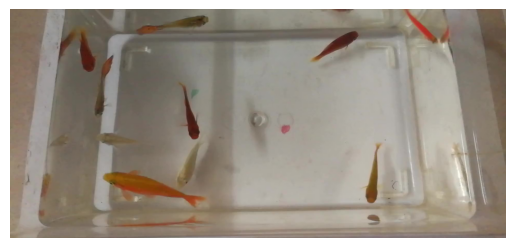

In [6]:
# Lee una imagen y la muestra en una ventana
img = cv2.imread(ovis_images + first_video_folder +'/img_0000001.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis('off')

In [130]:
def annToRLE(ann, frameId):
    """
    Convert annotation which can be polygons, uncompressed RLE to RLE.
    :return: binary mask (numpy 2D array)
    """
    h, w = ann['height'], ann['width']
    segm = ann['segmentations'][frameId]
    if type(segm) == "list":
        # polygon -- a single object might consist of multiple parts
        # we merge all parts into one mask rle code
        rles = maskUtils.frPyObjects(segm, h, w)
        rle = maskUtils.merge(rles)
    elif type(segm['counts']) == "list":
        # uncompressed RLE
        rle = maskUtils.frPyObjects(segm, h, w)
    else:
        # rle
        rle = segm
    return rle


def annToMask(ann, frameId):
    """
    Convert annotation which can be polygons, uncompressed RLE, or RLE to binary mask.
    :return: binary mask (numpy 2D array)
    """
    rle = annToRLE(ann, frameId)
    m = maskUtils.decode(rle)
    return m


def combineMasks(masks, width, height):
    # Crear una matriz vacía para la máscara combinada
    combined = np.zeros((height, width), dtype=np.uint8)

    # Combinar las máscaras en la matriz vacía
    for mask in masks:
        combined += mask  # Sumar la máscara a la máscara combinada

    # Aplicar umbral para obtener una única máscara binaria
    combined = np.where(combined > 0, 1, 0)
    return combined

def unifyMasks(masks, width, height):
    # Crear una matriz vacía para la máscara combinada
    unified = np.zeros((height, width), dtype=np.uint8)

    # Combinar las máscaras en la matriz vacía
    for mask in masks:
        unified += mask  # Sumar la máscara a la máscara combinada

    
    return unified

In [8]:
colors = [
    (255, 0, 0),    # Rojo
    (0, 255, 0),    # Verde
    (0, 0, 255),    # Azul
    (255, 255, 0),  # Amarillo
    (255, 0, 255),  # Magenta
    (0, 255, 255),  # Cian
    (128, 0, 0),    # Marrón oscuro
    (0, 128, 0),    # Verde oscuro
    (0, 0, 128),    # Azul oscuro
    (128, 128, 0),  # Amarillo oscuro
    (128, 0, 128),  # Magenta oscuro
    (0, 128, 128),  # Cian oscuro
    (255, 128, 0),  # Naranja
    (128, 255, 0),  # Lima
    (255, 0, 128),  # Rosa
    (128, 0, 255),  # Violeta
    (0, 255, 128),  # Turquesa
    (0, 128, 255),  # Azul claro
    (255, 128, 128), # Rosa claro
    (128, 255, 128)  # Verde claro
]

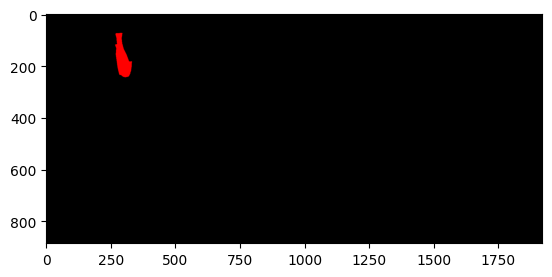

In [106]:
ann = []
video = vidTrain[0]
for a in annTrain:
    if a['video_id'] == video['id']:
        ann.append(a)
        break
    else: continue

mask = annToMask(ann[0], 0)
colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
colored_mask[:, :, 0] = mask * colors[0][0]
colored_mask[:, :, 1] = mask * colors[0][1]
colored_mask[:, :, 2] = mask * colors[0][2]
plt.imshow(colored_mask)

In [109]:
len(a)

11

In [135]:
ann = []
for a in annTrain:
    if a['video_id'] == video['id']:
        ann.append(a)
    else: continue

masks = []
for i,a in enumerate(ann):
    m = annToMask(a, 0)
    m = m * (i + 1)
    masks.append(m)

w, h = video['width'], video['height']
unified = unifyMasks(masks, w, h)

In [136]:
def load_images_from_folder(folder):
    images_files = os.listdir(folder)
    images = []
    for file in images_files:
        img = cv2.imread(os.path.join(folder,file))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append(img)
    return images

In [138]:
images = load_images_from_folder(ovis_images + first_video_folder)

In [150]:
model.xmem.clear_memory()
masks, logits, painted_images = model.generator(images=images[0:100], template_mask=unified)
model.xmem.clear_memory()

Imagenes [array([[[123, 105,  85],
        [123, 105,  85],
        [123, 105,  85],
        ...,
        [122, 110,  94],
        [119, 107,  91],
        [117, 105,  89]],

       [[123, 105,  85],
        [123, 105,  85],
        [123, 105,  85],
        ...,
        [123, 111,  95],
        [120, 108,  92],
        [118, 106,  90]],

       [[123, 105,  85],
        [123, 105,  85],
        [123, 105,  85],
        ...,
        [124, 112,  96],
        [121, 109,  93],
        [119, 107,  91]],

       ...,

       [[143, 127, 101],
        [143, 127, 101],
        [143, 127, 101],
        ...,
        [125, 112, 106],
        [125, 112, 106],
        [125, 112, 106]],

       [[143, 127, 101],
        [143, 127, 101],
        [143, 127, 101],
        ...,
        [124, 110, 107],
        [124, 110, 107],
        [124, 110, 107]],

       [[143, 127, 101],
        [143, 127, 101],
        [143, 127, 101],
        ...,
        [124, 110, 107],
        [124, 110, 107],
        [124, 

Tracking image:   0%|          | 0/100 [00:00<?, ?it/s]

Tracking image: 100%|██████████| 100/100 [24:42<00:00, 14.82s/it]


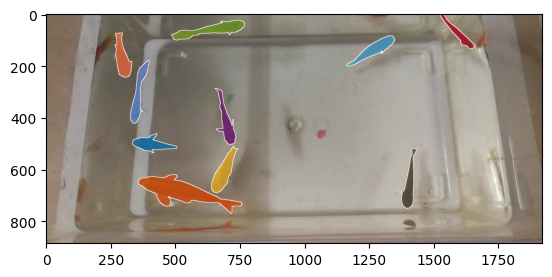

In [147]:
plt.imshow(painted_images[0])

In [148]:
def generate_video_from_frames(frames, output_path, fps=30):
    frames = torch.from_numpy(np.asarray(frames))
    if not os.path.exists(os.path.dirname(output_path)):
        os.makedirs(os.path.dirname(output_path))
    torchvision.io.write_video(output_path, frames, fps=fps, video_codec="libx264")
    return output_path

In [151]:
generate_video_from_frames(painted_images, output_path="./result/track/fish2.mp4")

'./result/track/fish2.mp4'

In [87]:
def print_rgb_mask(mask):
    colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3), dtype=np.uint8)
    colored_mask[:, :, 0] = mask * colors[0][0]
    colored_mask[:, :, 1] = mask * colors[0][1]
    colored_mask[:, :, 2] = mask * colors[0][2]
    plt.imshow(colored_mask)
    plt.show()
    

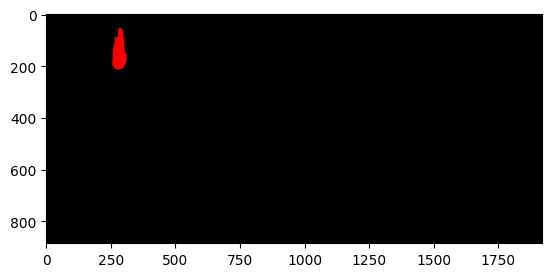

In [98]:
print_rgb_mask(logits[29])

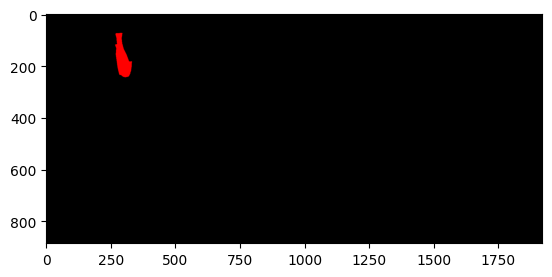

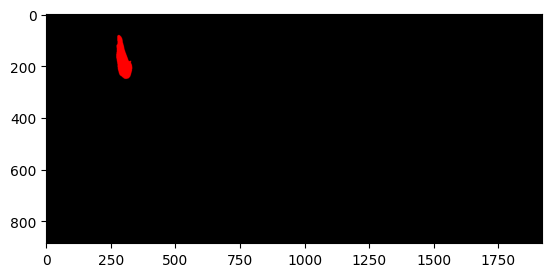

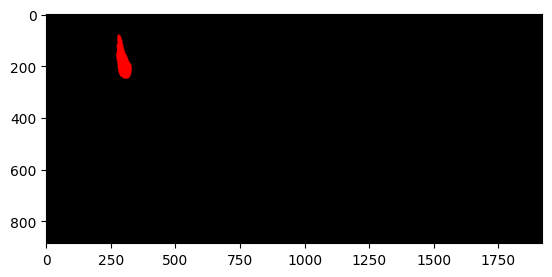

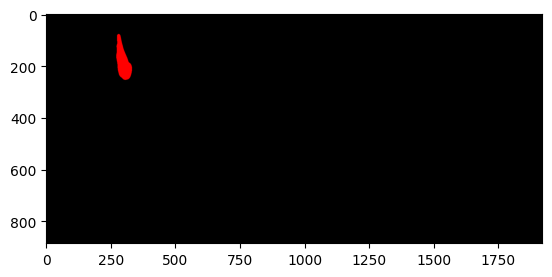

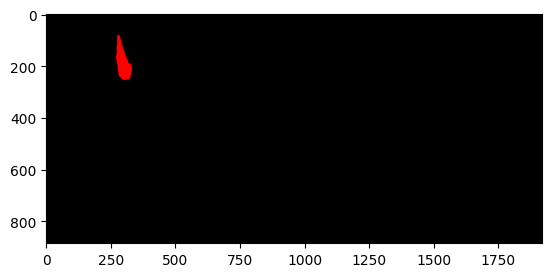

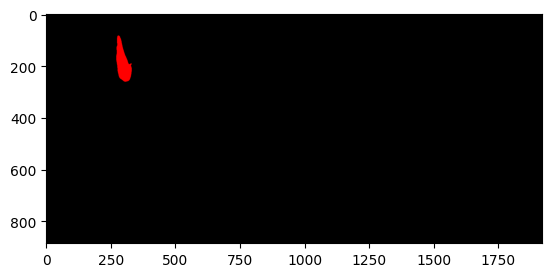

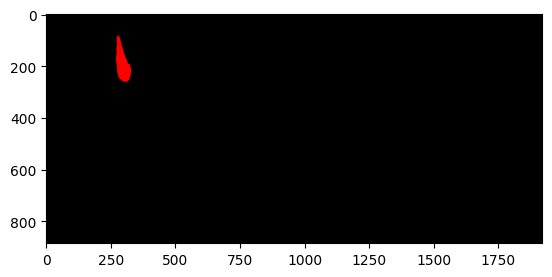

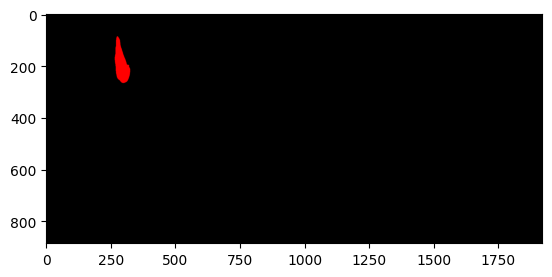

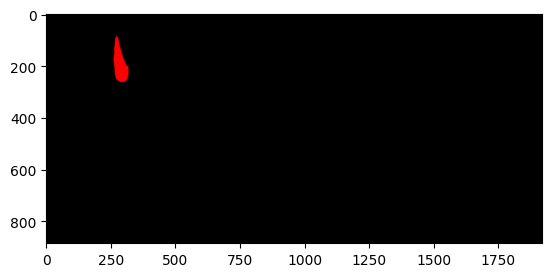

In [44]:
for i in range(0,9):
    colored_mask = np.zeros((masks[i].shape[0], masks[i].shape[1], 3), dtype=np.uint8)
    colored_mask[:, :, 0] = masks[i] * colors[0][0]
    colored_mask[:, :, 1] = masks[i] * colors[0][1]
    colored_mask[:, :, 2] = masks[i] * colors[0][2]
    plt.imshow(colored_mask)
    plt.show()